In [233]:
# !pip install scikit-learn
# !pip install tensorflow
# !pip install matplotlib
# !pip install pandas
# !pip install opencv-python
# !pip install seaborn

In [234]:
import h5py
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [235]:
import os
import cv2
import h5py
import numpy as np

def load_data(dataset_path, splits=['train', 'val', 'test']):
    X, y = {}, {}

    IMG_SIZE = 224

    Label_Mapping = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral', 7:'Contempt'}
    
    for split in splits:
        # PATH = os.path.join(path_prefix, dataset_name, split)
        PATH = os.path.join(dataset_path, split)
        X[split], y[split] = [], []
        for classes in Label_Mapping.values():
            class_path = os.path.join(PATH, classes)
            class_numeric = next((k for k, v in Label_Mapping.items() if v == classes), None)
            # print(f"{classes}_{class_numeric}_{class_path}")
            # print('---------------')

            try:
                for sample in os.listdir(class_path):
                    sample_path = os.path.join(class_path, sample)
                    image = cv2.imread(sample_path, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    X[split].append(image)
                    y[split].append(class_numeric)
            except:
                print(f"Dataset doesn't have class {classes}, therefore skipping.")
    
    # Convert to numpy arrays
    for split in splits:
        X[split] = np.array(X[split])
        y[split] = np.array(y[split])
        
    return X, y

In [295]:
NUM_CLASSES = 7
IMG_SHAPE = (120, 120, 3) # (224, 224, 3)
BATCH_SIZE = 8

TRAIN_EPOCH = 1 #100
TRAIN_LR = 1e-3
TRAIN_ES_PATIENCE = 0 #15
TRAIN_LR_PATIENCE = 9
TRAIN_MIN_LR = 1e-6
TRAIN_DROPOUT = 0.1

FT_EPOCH = 500
FT_LR = 1e-5
FT_LR_DECAY_STEP = 40.0#80.0
FT_LR_DECAY_RATE = 1
FT_ES_PATIENCE = 20
FT_DROPOUT = 0.2

ES_LR_MIN_DELTA = 0.003

In [275]:
def Model(component = 'Training', input_layer=None, sample_resizing=None, data_augmentation=None, 
          preprocess_input=None, base_model=None, self_attention=None, patch_extraction=None, 
          global_average_layer=None, pre_classification=None, prediction_layer=None):
    
    if component == 'Training':
        input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')
        sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")
        data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
        preprocess_input = tf.keras.applications.mobilenet.preprocess_input
        backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        backbone.trainable = False
        base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

        self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
        patch_extraction = tf.keras.Sequential([
            tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
            tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
            tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
        ], name='patch_extraction')
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
        pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                                tf.keras.layers.BatchNormalization()], name='pre_classification')
        prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

        inputs = input_layer
        x = sample_resizing(inputs)
        x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = patch_extraction(x)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
        x = pre_classification(x)
        x = tf.keras.layers.Reshape((1, 32))(x) 
        x = self_attention([x, x])
        x = tf.keras.layers.Reshape((32,))(x) 
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs, name='train-head')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model, input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer
    elif component == 'Finetuning':
        preprocess_input = tf.keras.applications.mobilenet.preprocess_input

        unfreeze = 59
        base_model.trainable = True
        fine_tune_from = len(base_model.layers) - unfreeze
        for layer in base_model.layers[:fine_tune_from]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_from:]:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False

        inputs = input_layer
        x = sample_resizing(inputs)
        x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = patch_extraction(x)
        x = tf.keras.layers.SpatialDropout2D(FT_DROPOUT)(x)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
        x = pre_classification(x)
        x = tf.keras.layers.Reshape((1, 32))(x) 
        x = self_attention([x, x])
        x = tf.keras.layers.Reshape((32,))(x) 
        x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs, name='finetune-backbone')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=FT_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

In [297]:
from tensorflow.keras.callbacks import ModelCheckpoint

def TrainPAttLite(data_directory, dataset_name, model_cp):
    X, y = load_data(data_directory, splits=['train', 'validation', 'test'])

    X_train, y_train = shuffle(X['train'], y['train'])
    X_valid, y_valid = X['validation'], y['validation']
    X_test, y_test = X['test'], y['test']

    X_train = np.array([cv2.resize(img, (120, 120)) for img in X_train])
    X_valid = np.array([cv2.resize(img, (120, 120)) for img in X_valid])
    X_test = np.array([cv2.resize(img, (120, 120)) for img in X_test])

    # Convert images to grayscale and resize them
    # X_train = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_train])
    # X_valid = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_valid])
    # X_test = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_test])
    
    # Convert grayscale to pseudo-RGB by repeating the grayscale values across 3 channels
    # X_train = np.repeat(np.expand_dims(X_train, axis=-1), 3, axis=-1)
    # X_valid = np.repeat(np.expand_dims(X_valid, axis=-1), 3, axis=-1)
    # X_test = np.repeat(np.expand_dims(X_test, axis=-1), 3, axis=-1)

    print("Shape of train_sample: {}".format(X_train.shape))
    print("Shape of train_label: {}".format(y_train.shape))
    print("Shape of valid_sample: {}".format(X_valid.shape))
    print("Shape of valid_label: {}".format(y_valid.shape))
    print("Shape of test_sample: {}".format(X_test.shape))
    print("Shape of test_label: {}".format(y_test.shape))

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    model, input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer = Model('Training')

    # Training Procedure
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=TRAIN_ES_PATIENCE, min_delta=ES_LR_MIN_DELTA, restore_best_weights=True)
    learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=TRAIN_LR_PATIENCE, verbose=0, min_delta=ES_LR_MIN_DELTA, min_lr=TRAIN_MIN_LR)
    checkpoint_callback = ModelCheckpoint( #Modification
        f'{dataset_name}_model_checkpoint.keras',  # The path to save the model
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Save the best model (with the highest validation accuracy)
        mode='max',  # 'max' for accuracy, 'min' for loss
        verbose=1  # Display messages when saving the model
    )

    if model_cp is not None:
        model = tf.keras.models.load_model(model_cp) if model_cp is not None else model
        input_layer = model.input
        sample_resizing = model.get_layer('resize')
        data_augmentation = model.get_layer('augmentation')
        base_model = model.get_layer('base_model')
        self_attention = model.get_layer('attention')
        patch_extraction = model.get_layer('patch_extraction')
        global_average_layer = model.get_layer('gap')
        pre_classification = model.get_layer('pre_classification')
        prediction_layer = model.get_layer('classification_head')

    print("Training")
    # print(input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer)
    history = model.fit(X_train, y_train, epochs=TRAIN_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
                        class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback, checkpoint_callback])
    # test_loss, test_acc = model.evaluate(X_test, y_test)
    # print(input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer)

    model = Model('Finetuning', input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer)
    
    # Custom function to ensure the scheduler output is a float
    def lr_schedule(epoch, lr):
        return float(scheduler(epoch))

    # Training Procedure
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=ES_LR_MIN_DELTA, patience=FT_ES_PATIENCE, restore_best_weights=True)
    scheduler = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=FT_LR, decay_steps=FT_LR_DECAY_STEP, decay_rate=FT_LR_DECAY_RATE)
    # scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)

    checkpoint_callback = ModelCheckpoint( #Modification
        f'{dataset_name}_model_finetune_checkpoint.keras',  # The path to save the model
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Save the best model (with the highest validation accuracy)
        mode='max',  # 'max' for accuracy, 'min' for loss
        verbose=1  # Display messages when saving the model
    )

    print("Finetuning")
    history_finetune = model.fit(X_train, y_train, epochs=FT_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
                                initial_epoch=history.epoch[-TRAIN_ES_PATIENCE], callbacks=[early_stopping_callback, scheduler_callback, tensorboard_callback, checkpoint_callback])
    # test_loss, test_acc = model.evaluate(X_test, y_test)

    model.save(f'{dataset_name}_ABC.keras')

In [ ]:
# # input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')
# # sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")
# # data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
# # preprocess_input = tf.keras.applications.mobilenet.preprocess_input
# # backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# # backbone.trainable = False
# # base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

# # self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
# # patch_extraction = tf.keras.Sequential([
# # tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
# # tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
# # tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
# # ], name='patch_extraction')
# # global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
# # pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
# #                                     tf.keras.layers.BatchNormalization()], name='pre_classification')
# # prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

# # model = Model('Finetuning', input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer)

# model = tf.keras.models.load_model('JAFFE_Structured.keras') 
# print(model.get_layer('universal_input'))
# print(model.get_layer('resize'))
# print(model.get_layer('augmentation'))
# # print(model.get_layer('universal_input')) 
# print(model.get_layer('base_model'))
# print(model.get_layer('attention'))
# print(model.get_layer('patch_extraction'))
# print(model.get_layer('gap'))
# print(model.get_layer('pre_classification'))
# print(model.get_layer('classification_head'))

<InputLayer name=universal_input, built=True>
<Resizing name=resize, built=True>
<Sequential name=augmentation, built=True>
<Functional name=base_model, built=True>
<Attention name=attention, built=True>
<Sequential name=patch_extraction, built=True>
<GlobalAveragePooling2D name=gap, built=True>
<Sequential name=pre_classification, built=True>
<Dense name=classification_head, built=True>


In [ ]:
TrainPAttLite('../../Datasets/FER_Structured', "FER_Structured", model_cp = None) #'FER_Structured_model_finetune_checkpoint.keras')

In [ ]:
# X, y = load_data('../../Datasets', dataset_name='JAFFE_Structured', splits=['train', 'validation', 'test'])
# # X, y = load_data('../../Datasets', dataset_name='FER_Structured', splits=['train', 'validation', 'test'])

# X_train, y_train = shuffle(X['train'], y['train'])
# X_valid, y_valid = X['validation'], y['validation']
# X_test, y_test = X['test'], y['test']

# # X_train, y_train = shuffle(X_train, y_train)

# print("Shape of train_sample: {}".format(X_train.shape))
# print("Shape of train_label: {}".format(y_train.shape))
# print("Shape of valid_sample: {}".format(X_valid.shape))
# print("Shape of valid_label: {}".format(y_valid.shape))
# print("Shape of test_sample: {}".format(X_test.shape))
# print("Shape of test_label: {}".format(y_test.shape))

# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(class_weights))
# print(class_weights)

Dataset doesn't have class Neutral, therefore skipping.
Dataset doesn't have class Contempt, therefore skipping.
Dataset doesn't have class Neutral, therefore skipping.
Dataset doesn't have class Contempt, therefore skipping.
Dataset doesn't have class Neutral, therefore skipping.
Dataset doesn't have class Contempt, therefore skipping.
Shape of train_sample: (128, 224, 224, 3)
Shape of train_label: (128,)
Shape of valid_sample: (41, 224, 224, 3)
Shape of valid_label: (41,)
Shape of test_sample: (44, 224, 224, 3)
Shape of test_label: (44,)
{0: np.float64(1.1851851851851851), 1: np.float64(0.8888888888888888), 2: np.float64(4.266666666666667), 3: np.float64(0.6274509803921569), 4: np.float64(0.927536231884058), 5: np.float64(0.8888888888888888)}


In [ ]:
# # Model Building
# input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')
# sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")
# data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), 
#                                         tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
# preprocess_input = tf.keras.applications.mobilenet.preprocess_input

# backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# backbone.trainable = False
# base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

# self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
# patch_extraction = tf.keras.Sequential([
#     tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
#     tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
#     tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
# ], name='patch_extraction')
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
# pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
#                                           tf.keras.layers.BatchNormalization()], name='pre_classification')
# prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

# inputs = input_layer
# x = sample_resizing(inputs)
# x = data_augmentation(x)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = patch_extraction(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
# x = pre_classification(x)
# x = tf.keras.layers.Reshape((1, 32))(x) #----
# x = self_attention([x, x])
# x = tf.keras.layers.Reshape((32,))(x) #----
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs, name='train-head')
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Training Procedure
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=TRAIN_ES_PATIENCE, min_delta=ES_LR_MIN_DELTA, restore_best_weights=True)
# learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=TRAIN_LR_PATIENCE, verbose=0, min_delta=ES_LR_MIN_DELTA, min_lr=TRAIN_MIN_LR)
# history = model.fit(X_train, y_train, epochs=TRAIN_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
#                     class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback])
# test_loss, test_acc = model.evaluate(X_test, y_test)

# # Model Finetuning
# print("\nFinetuning ...")
# unfreeze = 59
# base_model.trainable = True
# fine_tune_from = len(base_model.layers) - unfreeze
# for layer in base_model.layers[:fine_tune_from]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_from:]:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = False

# inputs = input_layer
# x = sample_resizing(inputs)
# x = data_augmentation(x)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = patch_extraction(x)
# x = tf.keras.layers.SpatialDropout2D(FT_DROPOUT)(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
# x = pre_classification(x)
# x = tf.keras.layers.Reshape((1, 32))(x) #----
# x = self_attention([x, x])
# x = tf.keras.layers.Reshape((32,))(x) #----
# x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs, name='finetune-backbone')
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=FT_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Custom function to ensure the scheduler output is a float
# def lr_schedule(epoch, lr):
#     return float(scheduler(epoch))

# # Training Procedure
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=ES_LR_MIN_DELTA, patience=FT_ES_PATIENCE, restore_best_weights=True)
# scheduler = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=FT_LR, decay_steps=FT_LR_DECAY_STEP, decay_rate=FT_LR_DECAY_RATE)
# # scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)
# scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)

# history_finetune = model.fit(X_train, y_train, epochs=FT_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
#                              initial_epoch=history.epoch[-TRAIN_ES_PATIENCE], callbacks=[early_stopping_callback, scheduler_callback, tensorboard_callback])
# test_loss, test_acc = model.evaluate(X_test, y_test)
# # model.save('model.h5')
# model.save('JAFFEmodel.keras')

Epoch 1/100


c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1745 - loss: 1.8551

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.1771 - loss: 1.8509 - val_accuracy: 0.1951 - val_loss: 1.7877 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1809 - loss: 1.7314 - val_accuracy: 0.1951 - val_loss: 1.7823 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4260 - loss: 1.6232 - val_accuracy: 0.1951 - val_loss: 1.7785 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4699 - loss: 1.7299 - val_accuracy: 0.2439 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5225 - loss: 1.3343 - val_accuracy: 0.3659 - val_loss: 1.7315 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5689 - loss: 1.1433 - val_accuracy: 0.3415 - val_loss: 1.6957 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7031 - loss: 0.8674 - val_accurac

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns

def TestPAttLite(data_directory, model_path, dataset=['test']):
    # Load the data (replace with your own dataset loading function)

    images = []
    labels = []
    for directory in dataset:
        X, y = load_data(data_directory, splits=[directory])
        X_dir, y_dir = X[directory], y[directory]

        X_dir = np.array([cv2.resize(img, (120, 120)) for img in X_dir])

        # # Convert images to grayscale and resize them
        # X_dir = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_dir])
        # # Convert grayscale to pseudo-RGB by repeating the grayscale values across 3 channels
        # X_dir = np.repeat(np.expand_dims(X_dir, axis=-1), 3, axis=-1)

        images.append(X_dir)
        labels.append(y_dir)

    # Convert images and labels to single arrays if needed (not nested)
    all_images = np.concatenate(images, axis=0)
    all_labels = np.concatenate(labels, axis=0)

    # Load the trained model
    model = load_model(model_path)

    # Make predictions on the test set
    y_pred = model.predict(all_images)

    # Get predicted class indices
    all_preds = np.argmax(y_pred, axis=1)
    
    # Get true class indices
    print("Labels: ", len(all_labels))
    print("Predictions: ", len(all_preds))

    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    # print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


Dataset doesn't have class Contempt, therefore skipping.


c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step
Labels:  3589
Predictions:  3589
Test Accuracy: 0.6138200055725829
Precision (Weighted): 0.6066379231891619
Precision (Macro): 0.5910757637804732
Precision (Micro): 0.6138200055725829
Recall (Weighted): 0.6138200055725829
Recall (Macro): 0.5746444943008476
Recall (Micro): 0.6138200055725829
F1 Score (Weighted): 0.6073549938994405
F1 Score (Macro): 0.5792376058926251
F1 Score (Micro): 0.6138200055725829

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.50      0.51       491
           1       0.58      0.45      0.51        55
           2       0.49      0.34      0.40       528
           3       0.80      0.85      0.83       879
           4       0.46      0.47      0.46       594
           5       0.71      0.74      0.73       416
           6       0.57      0.66      0.61       626

    accuracy                           0.61      3589
   macro avg       0.59      0.57    

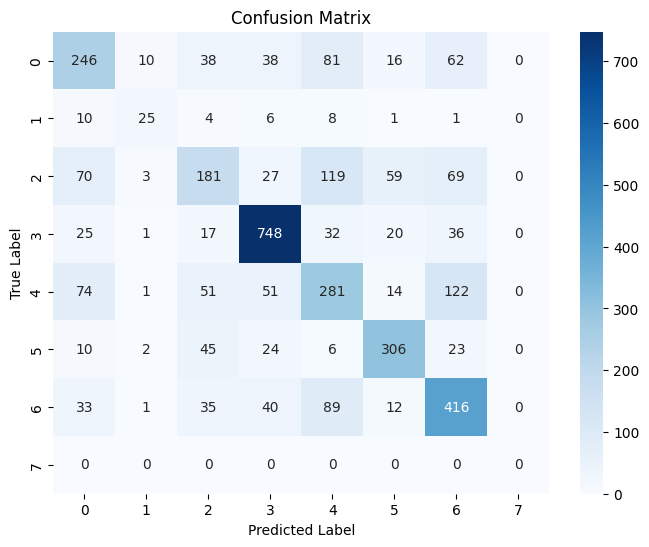

In [301]:
data_directory = '../../Datasets/FER_Structured'
# model_path = 'JAFFEmodel.keras'
model_path = 'FER_Structured_model_finetune_checkpoint.keras'

TestPAttLite(data_directory, model_path, dataset=['test'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.6780 - loss: 0.9676
Test Accuracy: 70.45%
Test Loss:  0.8966898322105408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Predicted Emotion: Neutral


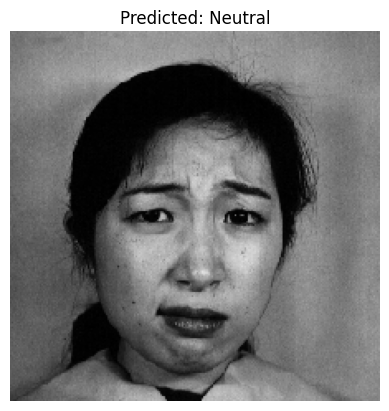

In [29]:
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model('JAFFEmodel.keras')

# # Evaluate or use the model for prediction
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_acc * 100:.2f}%")
# print("Test Loss: ", test_loss)

# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.preprocessing import image

# # Load and preprocess a single image
# def preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(120, 120))  # Resize to 224x224
#     img_array = image.img_to_array(img)  # Convert to array
#     img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#     img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)  # Normalize like training
#     return img_array

# # Example usage
# img_path = "TestImages/train_2_DIS.tiff"
# processed_img = preprocess_image(img_path)

# # Get model prediction
# predictions = model.predict(processed_img)

# # Get the class label with the highest probability
# predicted_class = np.argmax(predictions, axis=1)[0]

# # Map predicted class index back to label names
# class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']  # Modify based on your dataset
# predicted_label = class_labels[predicted_class]

# print(f"Predicted Emotion: {predicted_label}")

# import matplotlib.pyplot as plt

# # Load image for display
# img = image.load_img(img_path, target_size=(224, 224))

# # Show image with predicted label
# plt.imshow(img)
# plt.axis('off')
# plt.title(f"Predicted: {predicted_label}")
# plt.show()
